## Get env

In [1]:
!nvidia-smi

Sat Oct  2 20:50:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   45C    P8    24W / 370W |   2782MiB / 24576MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 環境によって処理を変えるためのもの
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')

IN_COLAB:False, IN_KAGGLE:False, LOCAL:True


In [3]:
# For Colab Download some datasets
# ==================
if IN_COLAB:
    # mount googledrive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy kaggle.json from googledrive
    ! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
    ! mkdir ~/.kaggle
    ! cp "/content/drive/MyDrive/kaggle/kaggle.json" ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    
    # if not os.path.exists("/content/input/train_short_audio"):
    #     !mkdir input
    #     !kaggle competitions download -c birdclef-2021
    #     !unzip /content/birdclef-2021.zip -d input

In [4]:
if IN_KAGGLE:
    !pip install --upgrade -q wandb
    !pip install -q pytorch-lightning
    !pip install torch_optimizer

## Import Libraries

In [5]:
# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
import os
import math
import random
import glob
from collections import defaultdict
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Utilities and Metrics
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import mean_absolute_error #[roc_auc_score, accuracy_score]

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.optimizer import Optimizer, required
import torch_optimizer as optim

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Callback, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger, CSVLogger

# Weights and Biases Tool
import wandb
os.environ["WANDB_API_KEY"]='68fa1bbcda0fcf7a56f3c33a0fafa45b02f1c52d'
wandb.login()

wandb: Currently logged in as: teyosan1229 (use `wandb login --relogin` to force relogin)


True

## Config

In [6]:
class CFG:
    debug = False
    competition='ventilator'
    exp_name = "exp007"
    seed = 29
    # model
    # img_size = 384
    
    # data
    target_col = 'pressure' # 目標値のある列名
    target_size = 1
    
    # optimizer
    optimizer_name = 'RAdam'
    lr = 5e-3
    weight_decay = 1e-6
    amsgrad = False
    
    # scheduler
    epochs = 50
    scheduler = 'CosineAnnealingLR'
    T_max = 50
    min_lr = 1e-6
    # criterion
    # u_out = 1 を考慮しないLoss
    criterion_name = 'CustomLoss1'
    
    # training
    train = True
    inference = True
    n_fold = 5
    trn_fold = [0,1,2,3,4]
    precision = 16 #[16, 32, 64]
    grad_acc = 2
    # DataLoader
    loader = {
        "train": {
            "batch_size": 64,
            "num_workers": 0,
            "shuffle": True,
            "pin_memory": True,
            "drop_last": True
        },
        "valid": {
            "batch_size": 96,
            "num_workers": 0,
            "shuffle": False,
            "pin_memory": True,
            "drop_last": False
        }
    }
    # pl
    trainer = {
        'gpus': 1,
        'progress_bar_refresh_rate': 1,
        'benchmark': False,
        'deterministic': True,
        }
    # LSTM
    num_layers = 4
    cate_seq_cols=['R', 'C'] # カテゴリー？
    cont_seq_cols=['time_step', 'u_in', 'u_out'] + ['breath_time', 'u_in_time']
    hidden_size=64

## Directory & LoadData

In [7]:
if IN_KAGGLE:
    INPUT_DIR = Path('../input/ventilator-pressure-prediction')
    OUTPUT_DIR = './'
elif IN_COLAB:
    INPUT_DIR = Path('/content/input/')
    OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/ventilator-pressure-prediction/{CFG.exp_name}/'
if LOCAL:
    INPUT_DIR = Path("F:/Kaggle/ventilator-pressure-prediction/data/input/")
    OUTPUT_DIR = f'F:/Kaggle/ventilator-pressure-prediction/data/output/{CFG.exp_name}/'

df_train = pd.read_csv(INPUT_DIR / "train.csv")
df_test = pd.read_csv(INPUT_DIR / "test.csv")
submission = pd.read_csv(INPUT_DIR / "sample_submission.csv")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if CFG.debug:
    CFG.epochs = 5
    #CFG.inference = False
    #df_train = df_train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)
    df_train = df_train.head(240000)

In [8]:
for c in ['u_in']:
    df_train[c] = np.log1p(df_train[c])
    df_test[c] = np.log1p(df_test[c])
    
r_map = {5: 0, 20: 1, 50: 2}
c_map = {10: 0, 20: 1, 50: 2}
df_train['R'] = df_train['R'].map(r_map)
df_test['R'] = df_test['R'].map(r_map)
df_train['C'] = df_train['C'].map(c_map)
df_test['C'] = df_test['C'].map(c_map)

display(df_train.head())
display(df_test.head())
display(submission.head())

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,1,2,0.000000,0.080043,0,5.837492
1,2,1,1,2,0.033652,2.964399,0,5.907794
2,3,1,1,2,0.067514,3.157395,0,7.876254
3,4,1,1,2,0.101542,3.170056,0,11.742872
4,5,1,1,2,0.135756,3.271690,0,12.234987


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,0,1,0.000000,0.000000,0
1,2,0,0,1,0.031904,2.141835,0
2,3,0,0,1,0.063827,2.750578,0
3,4,0,0,1,0.095751,3.101470,0
4,5,0,0,1,0.127644,3.307654,0


,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [9]:
# ====================================================
# FE
# ====================================================
def add_feature(df):
    # breath_time
    df['breath_time'] = df['time_step'] - df['time_step'].shift(1)
    df.loc[df['time_step'] == 0, 'breath_time'] = 0
    # u_in_time
    df['u_in_time'] = df['u_in'] - df['u_in'].shift(1)
    df.loc[df['time_step'] == 0, 'u_in_time'] = 0
    return df


df_train = add_feature(df_train)
df_test = add_feature(df_test)

## Utils

In [10]:
seed_everything(CFG.seed)
# LINEに通知
import requests
def send_line_notification(message):
    line_token = '8vBbxd0jENU39kV2ROEwp78jAzeankBFi7AG0JjoU3j'
    endpoint = 'https://notify-api.line.me/api/notify'
    message = f"{message}"
    payload = {'message': message}
    headers = {'Authorization': 'Bearer {}'.format(line_token)}
    requests.post(endpoint, data=payload, headers=headers)

Global seed set to 29


## CV Split

In [11]:
df_train["fold"] = -1
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train[CFG.target_col])):
#     df_train.loc[val_index, 'fold'] = int(n)
Fold = GroupKFold(n_splits=CFG.n_fold)
for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train[CFG.target_col], groups=df_train.breath_id.values)):
     df_train.loc[val_index, 'fold'] = int(n)
df_train['fold'] = df_train['fold'].astype(int)
print(df_train.groupby(['fold', 'breath_id']).size())

fold  breath_id
0     4            80
      16           80
      18           80
      20           80
      23           80
                   ..
4     125721       80
      125723       80
      125726       80
      125734       80
      125739       80
Length: 75450, dtype: int64


## Transforms

In [12]:
def get_transforms(phase: str):
    if phase == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ])
    elif phase == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ])


## Dataset

In [13]:
groups = df_train.groupby('breath_id').groups
keys = list(groups.keys())
idx=0
indexes = groups[keys[idx]]
indexes

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
           dtype='int64')

In [14]:
"""
breath_idで１まとまり？
"""
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.groups =df.groupby('breath_id').groups
        self.keys = list(self.groups.keys())
        #self.targets = df[CFG.target_col].values
        #self.transform = transform
        
    def __len__(self):
        return len(self.groups)
    
    def __getitem__(self, idx):
        indexes = self.groups[self.keys[idx]]
        df = self.df.iloc[indexes]
        cate_seq_x = torch.LongTensor(df[CFG.cate_seq_cols].values)
        cont_seq_x = torch.FloatTensor(df[CFG.cont_seq_cols].values)
        u_out = torch.LongTensor(df['u_out'].values)
        label = torch.FloatTensor(df['pressure'].values)
        return cate_seq_x, cont_seq_x, u_out, label
    
class TestDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.groups = df.groupby('breath_id').groups
        self.keys = list(self.groups.keys())
        
    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        indexes = self.groups[self.keys[idx]]
        df = self.df.iloc[indexes]
        cate_seq_x = torch.LongTensor(df[CFG.cate_seq_cols].values)
        cont_seq_x = torch.FloatTensor(df[CFG.cont_seq_cols].values)
        return cate_seq_x, cont_seq_x

どんなデータを取ってきてるのかの確認  
breath_id1個分のデータを何個かに分けてとってきてるっぽい

In [15]:
train_dataset = TrainDataset(df_train)
train_dataset[0]

(tensor([[1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2],
         [1, 2

In [16]:
df_train[df_train["breath_id"] ==1 ]

,id,breath_id,R,C,time_step,u_in,u_out,pressure,breath_time,u_in_time,fold
0,1,1,1,2,0.000000,0.080043,0,5.837492,0.000000,0.000000,4
1,2,1,1,2,0.033652,2.964399,0,5.907794,0.033652,2.884355,4
2,3,1,1,2,0.067514,3.157395,0,7.876254,0.033862,0.192997,4
3,4,1,1,2,0.101542,3.170056,0,11.742872,0.034028,0.012661,4
4,5,1,1,2,0.135756,3.271690,0,12.234987,0.034213,0.101634,4
...,...,...,...,...,...,...,...,...,...,...,...
75,76,1,1,2,2.553593,1.787496,1,6.399909,0.034092,0.000794,4
76,77,1,1,2,2.587754,1.788167,1,6.610815,0.034160,0.000671,4
77,78,1,1,2,2.621773,1.788729,1,6.329607,0.034020,0.000563,4
78,79,1,1,2,2.655746,1.789203,1,6.540513,0.033972,0.000474,4


## DataModule

In [17]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, train_data, valid_data, test_data, cfg):
        super().__init__()
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.cfg = cfg
        
    # 必ず呼び出される関数
    def setup(self, stage=None):
        self.train_dataset = TrainDataset(self.train_data)
        self.valid_dataset = TrainDataset(self.valid_data)
        self.test_dataset = TestDataset(self.test_data)
        
    # Trainer.fit() 時に呼び出される
    def train_dataloader(self):
        return DataLoader(self.train_dataset, **self.cfg.loader['train'])

    # Trainer.fit() 時に呼び出される
    def val_dataloader(self):
        return DataLoader(self.valid_dataset, **self.cfg.loader['valid'])

    def test_dataloader(self):
        return DataLoader(self.test_dataset, **self.cfg.loader['valid'])

In [18]:
data_module = DataModule(
          df_train[df_train['fold']!=0].reset_index(drop=True),
          df_train[df_train['fold']==0].reset_index(drop=True), 
          df_test,
          CFG  
        )
data_module.setup()

## Pytorch Lightning Module

In [19]:
# for n, m in model.named_modules()の処理がよくわからないから観察

# model = CustomModel(CFG)
# for n, m in model.named_modules():
#     print(f"n:{n}")
#     print(f"m:{m}")
#     if isinstance(m, nn.LSTM):
#         print(f'isinstance nn.LSTM')
#     print('='*50)

In [20]:
# model = CustomModel(CFG)
# Data = DataModule(df_train,df_train,df_train)
# Data.setup()
# loader = Data.train_dataloader()
# tmp = loader.__iter__()
# cate_seq_x, cont_seq_x, u_out, label = tmp.next()
# print(cate_seq_x.shape, cont_seq_x.shape, u_out.shape, label.shape)
# output = model(cate_seq_x,cont_seq_x)
# output.shape

In [21]:
# criterion = get_criterion()
# criterion(output,label,u_out).mean()

In [22]:
# ====================================================
# model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.hidden_size = cfg.hidden_size
        self.num_layers = cfg.num_layers
        # nn.Embedding(vocab_size, emb_dim)
        # 1層パーセプトロンのようなもの
        self.r_emb = nn.Embedding(3, 2, padding_idx=0)
        self.c_emb = nn.Embedding(3, 2, padding_idx=0)
        self.seq_emb = nn.Sequential(
            nn.Linear(4 + len(cfg.cont_seq_cols), self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.lstm = nn.GRU(self.hidden_size, self.hidden_size,
                            num_layers = self.num_layers,
                            dropout=0.2, batch_first=True, bidirectional=True)
        self.head = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.hidden_size * 2),
            nn.LayerNorm(self.hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(0.),
            nn.Linear(self.hidden_size * 2, 1),
        )
        # LSTMやGRUは直交行列に初期化する
        for n, m in self.named_modules():
            if isinstance(m, nn.LSTM):
                print(f'init {m}')
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.orthogonal_(param.data)
                    else:
                        nn.init.normal_(param.data)
            elif isinstance(m, nn.GRU):
                print(f"init {m}")
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.orthogonal_(param.data)
                    else:
                        nn.init.normal_(param.data)

    def forward(self, cate_seq_x, cont_seq_x):
        # cont_seq_x torch.Size([bs, 80, 5])
        bs = cont_seq_x.size(0)
        r_emb = self.r_emb(cate_seq_x[:,:,0]).view(bs, 80, -1) # torch.Size([bs, 80, 2])
        c_emb = self.c_emb(cate_seq_x[:,:,1]).view(bs, 80, -1) # torch.Size([bs, 80, 2])
        seq_x = torch.cat((r_emb, c_emb, cont_seq_x), 2) # torch.Size([bs, 80, 9])
        seq_emb = self.seq_emb(seq_x) # torch.Size([4, 80, 64])
        seq_emb, _ = self.lstm(seq_emb) # torch.Size([4, 80, 128])
        output = self.head(seq_emb).view(bs, -1) # torch.Size([4, 80])
        return output
    
def get_model(cfg):
    model = CustomModel(cfg)
    return model

# ====================================================
# criterion
# ====================================================
def compute_metric(df, preds):
    """
    Metric for the problem, as I understood it.
    """
    
    y = np.array(df['pressure'].values.tolist())
    w = 1 - np.array(df['u_out'].values.tolist())
    
    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)
    
    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()
    
    return mae


class VentilatorLoss(nn.Module):
    """
    Directly optimizes the competition metric
    """
    def __call__(self, preds, y, u_out):
        w = 1 - u_out
        mae = w * (y - preds).abs()
        mae = mae.sum(-1) / w.sum(-1)

        return mae

def get_criterion():
    if CFG.criterion_name == 'BCEWithLogitsLoss':
        # plだとto(device)いらない
        criterion = nn.BCEWithLogitsLoss(reduction="mean")
    if CFG.criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    if CFG.criterion_name == 'CustomLoss1':
        # [reference]https://www.kaggle.com/theoviel/deep-learning-starter-simple-lstm
        criterion = VentilatorLoss()
    else:
        raise NotImplementedError
    return criterion
# ====================================================
# optimizer
# ====================================================
def get_optimizer(model: nn.Module, config: dict):
    """
    input:
    model:model
    config:optimizer_nameやlrが入ったものを渡す
    
    output:optimizer
    """
    optimizer_name = config.optimizer_name
    if 'Adam' == optimizer_name:
        return Adam(model.parameters(),
                    lr=config.lr,
                    weight_decay=config.weight_decay,
                    amsgrad=config.amsgrad)
    elif 'RAdam' == optimizer_name:
        return optim.RAdam(model.parameters(),
                           lr=config.lr,
                           weight_decay=config.weight_decay)
    elif 'sgd' == optimizer_name:
        return SGD(model.parameters(),
                   lr=config.lr,
                   momentum=0.9,
                   nesterov=True,
                   weight_decay=config.weight_decay,)
    else:
        raise NotImplementedError

# ====================================================
# scheduler
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        """
        factor : 学習率の減衰率
        patience : 何ステップ向上しなければ減衰するかの値
        eps : nanとかInf回避用の微小数
        """
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        """
        T_max : 1 半周期のステップサイズ
        eta_min : 最小学習率(極小値)
        """
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        """
        T_0 : 初期の繰りかえし回数
        T_mult : サイクルのスケール倍率
        """
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
    else:
        raise NotImplementedError
    return scheduler

init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
[0.005, 0.004995067807706465, 0.0049802906959355376, 0.004955726983196358, 0.0049214736112410135, 0.004877665762479736, 0.004824476326477685, 0.004762115217638816, 0.004690828546769637, 0.004610897649792287, 0.004522637977440181, 0.004426397850318085, 0.0043225570842398186, 0.004211525491268757, 0.00409374126237685, 0.003969669238105037, 0.003839799074050002, 0.003704643308417237, 0.003564735339266899, 0.003420627319435353, 0.0032728879774401812, 0.003122100372968554, 0.0029688595958070195, 0.002813770417293979, 0.0026574449035635193, 0.0025005, 0.0023435550964364814, 0.002187229582706022, 0.0020321404041929816, 0.0018788996270314453, 0.0017281120225598196, 0.001580372680564648, 0.0014362646607331009, 0.0012963566915827622, 0.0011612009259499973, 0.0010313307618949636, 0.00090725873762315, 0.0007894745087312425, 0.0006784429157601824, 0.0005746021496819151, 0.00047836202255981916, 0.0003901023502077139, 0

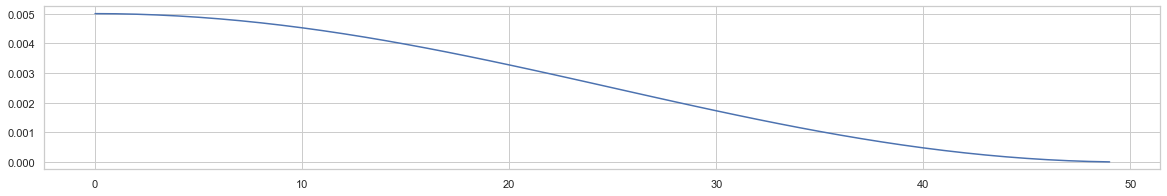

In [23]:
#model=timm.create_model(model_name="resnet18",pretrained=False)
model = get_model(CFG)
optimizer = get_optimizer(model, CFG)
scheduler = get_scheduler(optimizer)
from pylab import rcParams
lrs = []
for epoch in range(1, CFG.epochs+1):
    scheduler.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
print(lrs)
plt.plot(lrs)

In [24]:
optimizer.param_groups[0]["lr"]

5.932192293535238e-06

In [25]:
class Trainer(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.model = get_model(cfg)
        self.criterion = get_criterion()
    
    def forward(self, cate_seq_x, cont_seq_x):
        output = self.model(cate_seq_x, cont_seq_x)
        return output
    
    def training_step(self, batch, batch_idx):
        cate_seq_x, cont_seq_x, u_out, y = batch
        # mixup とかしたい場合はここに差し込む
        output = self.forward(cate_seq_x, cont_seq_x)
        labels = y#.unsqueeze(1)
        loss = self.criterion(output,labels ,u_out).mean()
        #self.log_dict(dict(train_loss=loss))
        self.log('train_loss', loss, on_step=True, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": output, "labels": labels}
    
    def training_epoch_end(self, outputs):
        # training_stepの出力のまとまりがoutputsに入っている。
        self.log("lr", self.optimizer.param_groups[0]['lr'], prog_bar=True, logger=True)
    
    def validation_step(self, batch, batch_idx):
        cate_seq_x, cont_seq_x, u_out, y = batch
        output = self.forward(cate_seq_x, cont_seq_x)
        labels = y#.unsqueeze(1)
        loss = self.criterion(output,labels ,u_out).mean()
        self.log('val_loss', loss, on_step= True, prog_bar=True, logger=True)
        return {"predictions": output,
                "labels": labels,
                "loss": loss.item()}
    
    def validation_epoch_end(self, outputs):
        preds = []
        labels = []
        loss = 0
        for output in outputs:
            preds += output['predictions']
            labels += output['labels']
            loss += output['loss']

        labels = torch.stack(labels)
        preds = torch.stack(preds)
        loss = loss/len(outputs)
        
        self.log("val_loss_epoch", loss, prog_bar=True, logger=True)
        
    def predict_step(self, batch, batch_idx):
        cate_seq_x, cont_seq_x = batch
        output = self.forward(cate_seq_x, cont_seq_x)
        return output
        
    def test_step(self, batch, batch_idx):
        cate_seq_x, cont_seq_x = batch       
        output = self.forward(cate_seq_x, cont_seq_x)
        return output
    
    def configure_optimizers(self):
        self.optimizer = get_optimizer(self, self.cfg)
        self.scheduler = {'scheduler': get_scheduler(self.optimizer),
                          'interval': 'step', # or 'epoch'
                          'frequency': 1}
        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

## Train

In [26]:
def train() -> None:
    for fold in range(CFG.n_fold):
        if not fold in CFG.trn_fold:
            continue
        print(f"{'='*38} Fold: {fold} {'='*38}")
        # Logger
        #======================================================
        lr_monitor = LearningRateMonitor(logging_interval='step')
        # 学習済重みを保存するために必要
        loss_checkpoint = ModelCheckpoint(
            dirpath=OUTPUT_DIR,
            filename=f"best_loss_fold{fold}",
            monitor="val_loss",
            save_last=True,
            save_top_k=1,
            save_weights_only=True,
            mode="min",
        )
        
        wandb_logger = WandbLogger(
            project=f'{CFG.competition}',
            group= f'{CFG.exp_name}',
            name = f'Fold{fold}',
            save_dir=OUTPUT_DIR
        )
        
        data_module = DataModule(
            df_train[df_train['fold']!=fold].reset_index(drop=True),
            df_train[df_train['fold']==fold].reset_index(drop=True), 
            df_test, 
            CFG
        )
        data_module.setup()
        
        CFG.T_max = int(math.ceil(len(data_module.train_dataloader())/CFG.grad_acc)*CFG.epochs)
        print(f"set schedular T_max {CFG.T_max}")
        #early_stopping_callback = EarlyStopping(monitor='val_auc',mode="max", patience=2)
        
        trainer = pl.Trainer(
            logger=wandb_logger,
            callbacks=[loss_checkpoint],#lr_monitor
            default_root_dir=OUTPUT_DIR,
            accumulate_grad_batches=CFG.grad_acc,
            max_epochs=CFG.epochs,
            precision=CFG.precision,
            **CFG.trainer
        )
        # 学習
        model = Trainer(CFG)
        trainer.fit(model, data_module)
        torch.save(model.model.state_dict(),OUTPUT_DIR + '/' + f'{CFG.exp_name}_fold{fold}.pth')
        # best loss modelのロード
        best_model = Trainer.load_from_checkpoint(cfg=CFG,checkpoint_path=loss_checkpoint.best_model_path)
        # テストデータを予測して保存
        if CFG.inference:
            predictions = trainer.predict(best_model, data_module.test_dataloader())
            preds = []
            for p in predictions:
                preds += p
            preds = torch.stack(preds).flatten()
            submission['pressure'] = preds.to('cpu').detach().numpy()
            submission.to_csv(OUTPUT_DIR + '/' + f'submission_fold{fold}.csv',index=False)
        
        wandb.finish()

        
        

In [27]:
train()
send_line_notification("[locl]finished")
wandb.finish()

====================================== Fold: 0 ======================================


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


set schedular T_max 23600
init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type           | Params
---------------------------------------------
0 | model     | CustomModel    | 291 K 
1 | criterion | VentilatorLoss | 0     
---------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:398: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\deprecated_api.py:33: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  "`Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6."
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "


init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 943it [00:00, ?it/s]

train_loss,0.50668
epoch,49
trainer/global_step,23599
_step,8471
_runtime,5826
_timestamp,1633181288
val_loss_step,0.5385
val_loss_epoch,0.43853
lr,0.0


train_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃█▃▃▄▄▄▄▄▄▄▄
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss_step,█▆▄▅▅▄▃▅▄▃▃▂▃▂▃▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁
val_loss_epoch,█▆▅▅▄▃▃▅▄▄▃▂▃▂▂▃▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


====================================== Fold: 1 ======================================


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


set schedular T_max 23600
init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type           | Params
---------------------------------------------
0 | model     | CustomModel    | 291 K 
1 | criterion | VentilatorLoss | 0     
---------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\deprecated_api.py:33: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  "`Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6."
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "


init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 943it [00:00, ?it/s]

train_loss,0.4625
epoch,49
trainer/global_step,23599
_step,8471
_runtime,5811
_timestamp,1633187174
val_loss_step,0.42598
val_loss_epoch,0.42117
lr,0.0


train_loss,█▃▃▄▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃█▃▃▄▄▄▄▄▄▄▄
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss_step,█▆▆▆▄▄▄▃▃▄▃▃▃▂▃▂▂▃▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_loss_epoch,█▆▆▄▃▄▄▃▃▄▃▄▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


====================================== Fold: 2 ======================================


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


set schedular T_max 23600
init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type           | Params
---------------------------------------------
0 | model     | CustomModel    | 291 K 
1 | criterion | VentilatorLoss | 0     
---------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\deprecated_api.py:33: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  "`Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6."
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "


init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 943it [00:00, ?it/s]

train_loss,0.5392
epoch,49
trainer/global_step,23599
_step,8471
_runtime,5809
_timestamp,1633193058
val_loss_step,0.37473
val_loss_epoch,0.45337
lr,0.0


train_loss,█▃▃▃▃▂▂▂▃▂▂▂▂▂▃▂▁▂▂▁▂▂▂▃▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃█▃▃▄▄▄▄▄▄▄▄
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss_step,█▇▆▄▅▄▅▄▃▄▃▄▅▂▃▃▃▄▂▂▂▂▃▂▅▂▂▂▃▁▁▂▂▁▁▁▂▁▁▁
val_loss_epoch,█▆▅▆▄▃▄▃▃▃▂▃▃▂▂▂▂▃▂▂▂▂▂▂▄▄▁▁▂▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


====================================== Fold: 3 ======================================


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


set schedular T_max 23600
init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type           | Params
---------------------------------------------
0 | model     | CustomModel    | 291 K 
1 | criterion | VentilatorLoss | 0     
---------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\deprecated_api.py:33: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  "`Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6."
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "


init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 943it [00:00, ?it/s]

train_loss,0.46076
epoch,49
trainer/global_step,23599
_step,8471
_runtime,5815
_timestamp,1633198950
val_loss_step,0.60505
val_loss_epoch,0.43404
lr,0.0


train_loss,█▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃█▃▃▄▄▄▄▄▄▄▄
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss_step,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_epoch,█▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


====================================== Fold: 4 ======================================


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


set schedular T_max 23600
init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


wandb: wandb version 0.12.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type           | Params
---------------------------------------------
0 | model     | CustomModel    | 291 K 
1 | criterion | VentilatorLoss | 0     
---------------------------------------------
291 K     Trainable params
0         Non-trainable params
291 K     Total params
1.164     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

D:\python\Anaconda3\lib\site-packages\pytorch_lightning\trainer\deprecated_api.py:33: LightningDeprecationWarning: `Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6.
  "`Trainer.train_loop` has been renamed to `Trainer.fit_loop` and will be removed in v1.6."
D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "


init GRU(64, 64, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 943it [00:00, ?it/s]

train_loss,0.45572
epoch,49
trainer/global_step,23599
_step,8471
_runtime,5832
_timestamp,1633204858
val_loss_step,0.48954
val_loss_epoch,0.44702
lr,0.0


train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃█▃▃▄▄▄▄▄▄▄▄
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss_step,█▆▅▅▃▅▄▄▃▃▃▂▄▄▂▂▂▂▃▂▂▂▂▂▂▁▃▂▂▂▁▁▁▂▂▂▁▂▁▁
val_loss_epoch,█▇▅▅▄▄▄▄▃▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [28]:
# print( "="*20,"last weight", "="*20)
#         print(model.state_dict()['model.seq_emb.0.weight'][0])
#         print( "="*20,"best weight", "="*20)
# model = Trainer(CFG)
# fold=0
# model = Trainer.load_from_checkpoint(checkpoint_path=OUTPUT_DIR + '/' + f'best_loss_fold{fold}.ckpt',cfg=CFG)
# model.state_dict()['model.seq_emb.0.weight'][0]

+ TestDatasetでなぜu_outを使っていない？
+ hidden_sizeの指す場所がよくわかってない

In [29]:
# class Trainer(pl.LightningModule):
#     def training_step(self, batch, batch_idx):
#         self.log('train_loss', loss)
#         return {"loss": loss, "predictions": output, "labels": labels}
    
#     def training_epoch_end(self, outputs):
#         pass
    
#     def validation_step(self, batch, batch_idx):
#         self.log('val_loss', loss, on_step= True, prog_bar=True, logger=True)
#         return {"predictions": output,"labels": labels,"loss": loss.item()}

#     def validation_epoch_end(self, outputs):
#         self.log("val_loss_epoch", loss, prog_bar=True, logger=True)